In [113]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import datatools
import datetime
import pvlib
import math
import statistics
from math import sqrt

%matplotlib inline 
mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('whitegrid')
sns.set_context("poster", font_scale=1)

In [94]:
#identify module names 
mod_names = 'LG', 'Panasonic', 'Can270', 'Can275', 'HanQPlus', 'HanQPeak', 'MissionSolar', 'Jinko'

#input file names : 'temp_inputs_112021.csv' & 'temp_inputs_052021.csv'
#read in previously generated data
inputs = pd.read_csv('temp_inputs_052021.csv', index_col='Unnamed: 0')
inputs.index = pd.to_datetime(inputs.index)
#inputs.dropna(inplace=True)
#this csv has temperature data horizontally instead of vertically for different types of analyses
mod_temps = pd.read_csv('modstrtemp_052021.csv')

In [76]:
#creating a df of system specific values

mod_data = {'LG': [18,1.686, 1.016, 24.229, 7.182, 45, 0.1871],
        'Panasonic': [18.5, 1.59, 1.053, 24.614, 7.878, 44, 0.1950],
        'Can270': [18.2, 1.65, 0.992, 31.088, 4.865, 45, 0.1706],
        'Can275': [18.2, 1.65, 0.992, 28.825, 4.452, 45, 0.1699],
        'HanQPlus': [18.8, 1.67, 1, 21.767, 6.585, 45,0.1676 ],
        'HanQPeak': [18.8, 1.67, 1, 30.536, 5.019, 45, 0.1864],
        'MissionSolar': [18.2, 1.664, 0.999, 22.678, 6.352, 44, 0.1881],
        'Jinko': [19, 1.65, 0.992, 27.308, 4.946, 45, 0.1720]}
 
# Creates pandas DataFrame.
mod_coeffs = pd.DataFrame(mod_data, index=['Mass', 'Length', 'Width', 'U0', 'U1', 'NOCT', 'eta'])


In [36]:
mod_coeffs

,LG,Panasonic,Can270,Can275,HanQPlus,HanQPeak,MissionSolar,Jinko
Mass,18.0000,18.500,18.2000,18.2000,18.8000,18.8000,18.2000,19.000
Length,1.6860,1.590,1.6500,1.6500,1.6700,1.6700,1.6640,1.650
Width,1.0160,1.053,0.9920,0.9920,1.0000,1.0000,0.9990,0.992
U0,24.2290,24.614,31.0880,28.8250,21.7670,30.5360,22.6780,27.308
U1,7.1820,7.878,4.8650,4.4520,6.5850,5.0190,6.3520,4.946
NOCT,45.0000,44.000,45.0000,45.0000,45.0000,45.0000,44.0000,45.000
eta,0.1871,0.195,0.1706,0.1699,0.1676,0.1864,0.1881,0.172


In [101]:
#Generate an empty df to store appended results
results = []

In [102]:
for mod_name in mod_names:    

    module = mod_coeffs[mod_name]
    start = inputs.index[0]
    end = inputs.index[-1]
    m_u = (module['Mass'])/((module['Length'])*(module['Width']))  
    
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

   
    # -----------------------------------------------------------------------------------------------------------------

    print('Starting Temperature Models')
    
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    
    mod_sapm = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b']).to_frame()    
    mod_sapm.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)

    mod_sapm['Model'] = 'SAPM'
    mod_sapm['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    mod_sapm['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    mod_sapm['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    mod_sapm['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    mod_sapm['TmStamp'] = mod_sapm.index
    mod_sapm['System'] = mod_name
    results.append(mod_sapm)

    mod_trans_sapm = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5])).to_frame()
    mod_trans_sapm.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    mod_trans_sapm['Model'] = 'SAPM - Transient'
    mod_trans_sapm['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    mod_trans_sapm['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    mod_trans_sapm['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    mod_trans_sapm['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    mod_trans_sapm['TmStamp'] = mod_trans_sapm.index
    mod_trans_sapm['System'] = mod_name
    results.append(mod_trans_sapm)
    
    sapm_cell = pvlib.temperature.sapm_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp']
                                            ,wind_speed=mod_inputs['wind_speed'], a=temperature_model_parameters['a'], b=temperature_model_parameters['b'], 
                                            deltaT = temperature_model_parameters['deltaT']).to_frame()
    sapm_cell.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    sapm_cell['Model'] = 'SAPM Cell'
    sapm_cell['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    sapm_cell['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    sapm_cell['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    sapm_cell['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    sapm_cell['TmStamp'] = sapm_cell.index
    sapm_cell['System'] = mod_name
    results.append(sapm_cell)
    
    print('SAPM complete')
    
    # -----------------------------------------------------------------------------------------------------------------
    
    ross_cell = pvlib.temperature.ross(poa_global=mod_inputs['poa_global'],temp_air = mod_inputs['amb_temp'],noct=module['NOCT']).to_frame()
    ross_cell.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    ross_cell['Model'] = 'Ross Cell'
    ross_cell['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    ross_cell['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    ross_cell['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    ross_cell['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    ross_cell['TmStamp'] = ross_cell.index
    ross_cell['System'] = mod_name
    results.append(ross_cell)
    
    # -----------------------------------------------------------------------------------------------------------------
    
    pvsyst_cell = pvlib.temperature.pvsyst_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed']).to_frame()
    pvsyst_cell.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    pvsyst_cell['Model'] = 'PVSyst Cell'
    pvsyst_cell['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    pvsyst_cell['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    pvsyst_cell['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    pvsyst_cell['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    pvsyst_cell['TmStamp'] = pvsyst_cell.index
    pvsyst_cell['System'] = mod_name
    results.append(pvsyst_cell)
                                  
    # -----------------------------------------------------------------------------------------------------------------
  
    sam_cell = pvlib.temperature.noct_sam(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed'],
                                          noct = module['NOCT'], module_efficiency = module['eta']).to_frame()
    sam_cell.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    sam_cell['Model'] = 'NOCT SAM'
    sam_cell['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    sam_cell['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    sam_cell['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    sam_cell['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    sam_cell['TmStamp'] = sam_cell.index
    sam_cell['System'] = mod_name
    results.append(sam_cell)
                               
    # -----------------------------------------------------------------------------------------------------------------

                                  #faiman
    temp_faiman = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1']).to_frame()
    temp_faiman.rename(columns = {0 : 'Modeled Temperature'}, inplace = True)
    temp_faiman['Model']='Faiman'
    temp_faiman['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    temp_faiman['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    temp_faiman['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    temp_faiman['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    temp_faiman['TmStamp']=temp_faiman.index
    temp_faiman['System'] = mod_name
    results.append(temp_faiman)
    
    # -----------------------------------------------------------------------------------------------------------------
   
    fuentes_temp = pvlib.temperature.fuentes(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], 
               wind_speed=mod_inputs['wind_speed'], noct_installed=module['NOCT'], module_height=2, 
                              wind_height=10, emissivity=0.84, absorption=0.83, surface_tilt=35, 
                              module_width=module['Width'], module_length=module['Length']).to_frame()
    fuentes_temp.rename(columns = {'tmod' : 'Modeled Temperature'}, inplace = True)
    fuentes_temp['Model']='Fuentes'
    fuentes_temp['Mod Temp Str 1'] = mod_inputs['Mod Temp Str 1']
    fuentes_temp['Mod Temp Str 2'] = mod_inputs['Mod Temp Str 2']
    fuentes_temp['Mod Temp Str 3'] = mod_inputs['Mod Temp Str 3']
    fuentes_temp['Mod Temp Str 4'] = mod_inputs['Mod Temp Str 4']
    fuentes_temp['TmStamp']=fuentes_temp.index
    fuentes_temp['System'] = mod_name
    results.append(fuentes_temp)
    
    # -----------------------------------------------------------------------------------------------------------------


    print('Finished ' + mod_name)
    # -----------------------------------------------------------------------------------------------------------------
    del mod_inputs

Starting Temperature Models
SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished LG
Starting Temperature Models
SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished Panasonic
Starting Temperature Models
SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished Can270
Starting Temperature Models
SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished Can275
Starting Temperature Models
SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished HanQPlus
Starting Temperature Models
SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished HanQPeak
Starting Temperature Models
SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished MissionSolar
Starting Temperature Models
SAPM complete


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished Jinko


In [103]:
#Concatenate all of the results from every system with every model
results = pd.concat(results, ignore_index=True)
results.index = results.TmStamp

#### Visualizing Results

In [104]:
#creating results horizontally to be able to take mean/median/min/max etc
#pick a system to focus on
system = 'MissionSolar'
sysresults = results.loc[results['System']==system]

final = inputs.loc[inputs['System']== system]
final = inputs.loc[~inputs.index.duplicated(), :]
daterng_all = pd.date_range(start=start, end=end, freq="T")
final = final.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

for mod_name in mod_names:    

    module = mod_coeffs[mod_name]
    start = start
    end = end
    m_u = (module['Mass'])/((module['Length'])*(module['Width']))  
    
    mod_inputs = inputs.loc[inputs['System']==mod_name]
    mod_inputs = inputs.loc[~inputs.index.duplicated(), :]
    daterng_all = pd.date_range(start=start, end=end, freq="T")
    mod_inputs = mod_inputs.sort_index().reindex(daterng_all.sort_values(),method= 'pad')

   
    # -----------------------------------------------------------------------------------------------------------------

    print('Starting Temperature Models')
    
    #sapm_module
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
    
    final[mod_name + ' SAPM'] = pvlib.temperature.sapm_module(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                            a=temperature_model_parameters['a'], b=temperature_model_parameters['b']) 
   

    final[mod_name + ' SAPM - Transient'] = pvlib.temperature.prilliman(temp_cell = mod_sapm['Modeled Temperature'], wind_speed=mod_inputs['wind_speed'], 
                                                                        unit_mass=m_u, coefficients=np.array([.0046,4.5537e-4,-2.2586e-4,-1.5661e-5]))
   
    final[mod_name + ' SAPM Cell'] = pvlib.temperature.sapm_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp']
                                            ,wind_speed=mod_inputs['wind_speed'], a=temperature_model_parameters['a'], b=temperature_model_parameters['b'], 
                                            deltaT = temperature_model_parameters['deltaT'])

    # -----------------------------------------------------------------------------------------------------------------
    
    final[mod_name + ' Ross Cell'] = pvlib.temperature.ross(poa_global=mod_inputs['poa_global'],temp_air = mod_inputs['amb_temp'],noct=module['NOCT'])
   
    # -----------------------------------------------------------------------------------------------------------------
    
    final[mod_name + ' PVSyst Cell'] = pvlib.temperature.pvsyst_cell(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed']).to_frame()
 
    # -----------------------------------------------------------------------------------------------------------------
  
    final[mod_name + ' NOCT SAM'] = pvlib.temperature.noct_sam(poa_global=mod_inputs['poa_global'], temp_air = mod_inputs['amb_temp'] ,wind_speed=mod_inputs['wind_speed'],
                                          noct = module['NOCT'], module_efficiency = module['eta'])
 
    # -----------------------------------------------------------------------------------------------------------------

    final[mod_name + ' Faiman'] = pvlib.temperature.faiman(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], wind_speed=mod_inputs['wind_speed'],
                           u0=module['U0'], u1=module['U1'])

    # -----------------------------------------------------------------------------------------------------------------
   
    final[mod_name + ' Fuentes'] = pvlib.temperature.fuentes(poa_global=mod_inputs['poa_global'], temp_air=mod_inputs['amb_temp'], 
               wind_speed=mod_inputs['wind_speed'], noct_installed=module['NOCT'], module_height=2, 
                              wind_height=10, emissivity=0.84, absorption=0.83, surface_tilt=35, 
                              module_width=module['Width'], module_length=module['Length'])
  
    # -----------------------------------------------------------------------------------------------------------------
    print('Finished ' + mod_name)
    # -----------------------------------------------------------------------------------------------------------------
    del mod_inputs

Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished LG
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished Panasonic
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished Can270
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished Can275
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished HanQPlus
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished HanQPeak
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished MissionSolar
Starting Temperature Models


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:976: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


Finished Jinko


In [105]:
#find the minimum and maximum measured temperature at each timestep

mod_temps['Min Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4',
       'JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].min(axis=1)
mod_temps['Max Measured Temp'] = mod_temps[['LGMod Temp Str 1', 'LGMod Temp Str 2', 'LGMod Temp Str 3','LGMod Temp Str 4', 'PanasonicMod Temp Str 1','PanasonicMod Temp Str 2', 'PanasonicMod Temp Str 3','PanasonicMod Temp Str 4', 'Can270Mod Temp Str 1','Can270Mod Temp Str 4', 'Can275Mod Temp Str 1', 'Can275Mod Temp Str 4','HanQPlusMod Temp Str 2', 'HanQPlusMod Temp Str 3','HanQPeakMod Temp Str 2', 'HanQPeakMod Temp Str 3','MissionSolarMod Temp Str 1', 'MissionSolarMod Temp Str 2','MissionSolarMod Temp Str 3', 'MissionSolarMod Temp Str 4',
       'JinkoMod Temp Str 1', 'JinkoMod Temp Str 2', 'JinkoMod Temp Str 3','JinkoMod Temp Str 4']].max(axis=1)

In [106]:
#finding mean and median of models interested in plotting, can specify 3 below

model1 = 'SAPM Cell'
model2 = 'Ross Cell'
model3 = 'PVSyst Cell'

final['Mean'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,
                       'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].mean(axis=1)
final['Median'] = final[['LG '+model1, 'LG '+model2, 'LG '+model3,'Panasonic '+model1, 'Panasonic '+model2, 'Panasonic '+model3,'Can270 '+model1, 'Can270 '+model2, 'Can270 '+model3,'Can275 '+model1, 'Can275 '+model2, 'Can275 '+model3,
                       'HanQPlus '+model1, 'HanQPlus '+model2, 'HanQPlus '+model3,'HanQPeak '+model1, 'HanQPeak '+model2, 'HanQPeak '+model3,'MissionSolar '+model1, 'MissionSolar '+model2, 'MissionSolar '+model3,'Jinko '+model1, 'Jinko '+model2, 'Jinko '+model3]].median(axis=1)

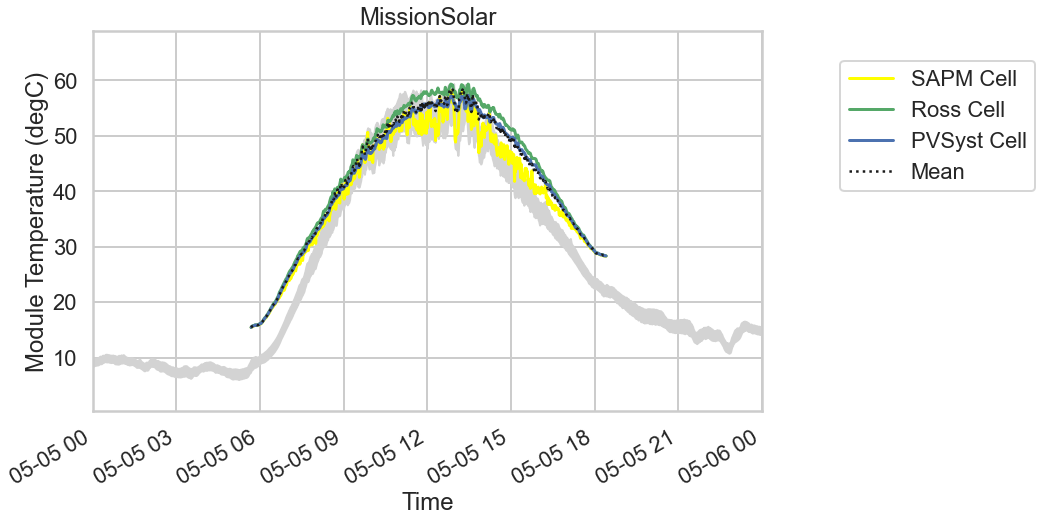

In [108]:

#this model is arbitrary, just need the index
modresults = sysresults.loc[sysresults['Model']=='SAPM']
x = modresults['TmStamp']
lower = mod_temps['Min Measured Temp']
upper = mod_temps['Max Measured Temp']

y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model1]
plt.plot(x, y, 'yellow')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model2]
plt.plot(x, y, 'g')
y = sysresults['Modeled Temperature'].loc[sysresults['Model']==model3]
plt.plot(x, y, 'b')

plt.xticks(rotation=30, ha='right')

y=final['Mean']
plt.plot(x, y, 'k:', linewidth=2.5)

plt.fill_between(x, lower, upper, color='lightgray')


plt.xlim(modresults.index[5760],modresults.index[7201])
#plt.xlim('2021-11-01 06:00:00-07:00','2021-11-02 19:00:00-07:00')
plt.ylabel('Module Temperature (degC)')
plt.xlabel('Time')
plt.title(system)
plt.legend([model1,model2,model3, 'Mean'] ,loc='center left', bbox_to_anchor=(1.1, 0.75))



In [135]:
#Calculate NMBE, MAPE, RMSE
strings = ['Mod Temp Str 1','Mod Temp Str 2','Mod Temp Str 3','Mod Temp Str 4']

for string in strings:
       sysresults['Diff ' + string] = 100 * (sysresults['Modeled Temperature'] - sysresults[string]) / (sysresults[string])
        
for string in strings:
    sysresults['Abs%Diff ' + string] = abs(sysresults['Diff ' + string])
    
    
    
sysresults['MAPE'] = ((sysresults.iloc[:,[-4,-3,-2,-1]].mean(axis=1)))
    
all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
twth_rtd = ['HanQPlus', 'HanQPeak']
onfo_rtd = ['Can 270', 'Can275']
    
if system in all_rtd: 
    sysresults['NMBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'] + sysresults['Diff Mod Temp Str 4'])/4
elif system in twth_rtd:
    sysresults['NMBE'] = (sysresults['Diff Mod Temp Str 2'] + sysresults['Diff Mod Temp Str 3'])/2
else:
    sysresults['NMBE'] = (sysresults['Diff Mod Temp Str 1'] + sysresults['Diff Mod Temp Str 4'])/2
    
if system in all_rtd: 
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2
                            + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/4)**0.5
elif system in twth_rtd:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 2'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 3'])**2)/2)**0.5
else:
    sysresults['RMSE'] = (((sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 1'])**2 + (sysresults['Modeled Temperature'] - sysresults['Mod Temp Str 4'])**2)/2)**0.5
    


C:\Users\lmdevil\AppData\Local\Temp\ipykernel_11616\166411736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sysresults['Diff ' + string] = 100 * (sysresults['Modeled Temperature'] - sysresults[string]) / (sysresults[string])
C:\Users\lmdevil\AppData\Local\Temp\ipykernel_11616\166411736.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sysresults['Abs%Diff ' + string] = abs(sysresults['Diff ' + string])
C:\Users\lmdevil\AppData\Local\Temp\ipykernel_11616\166411736.py:12: SettingWithCopyWarning: 
A va

(0.0, 5.0)

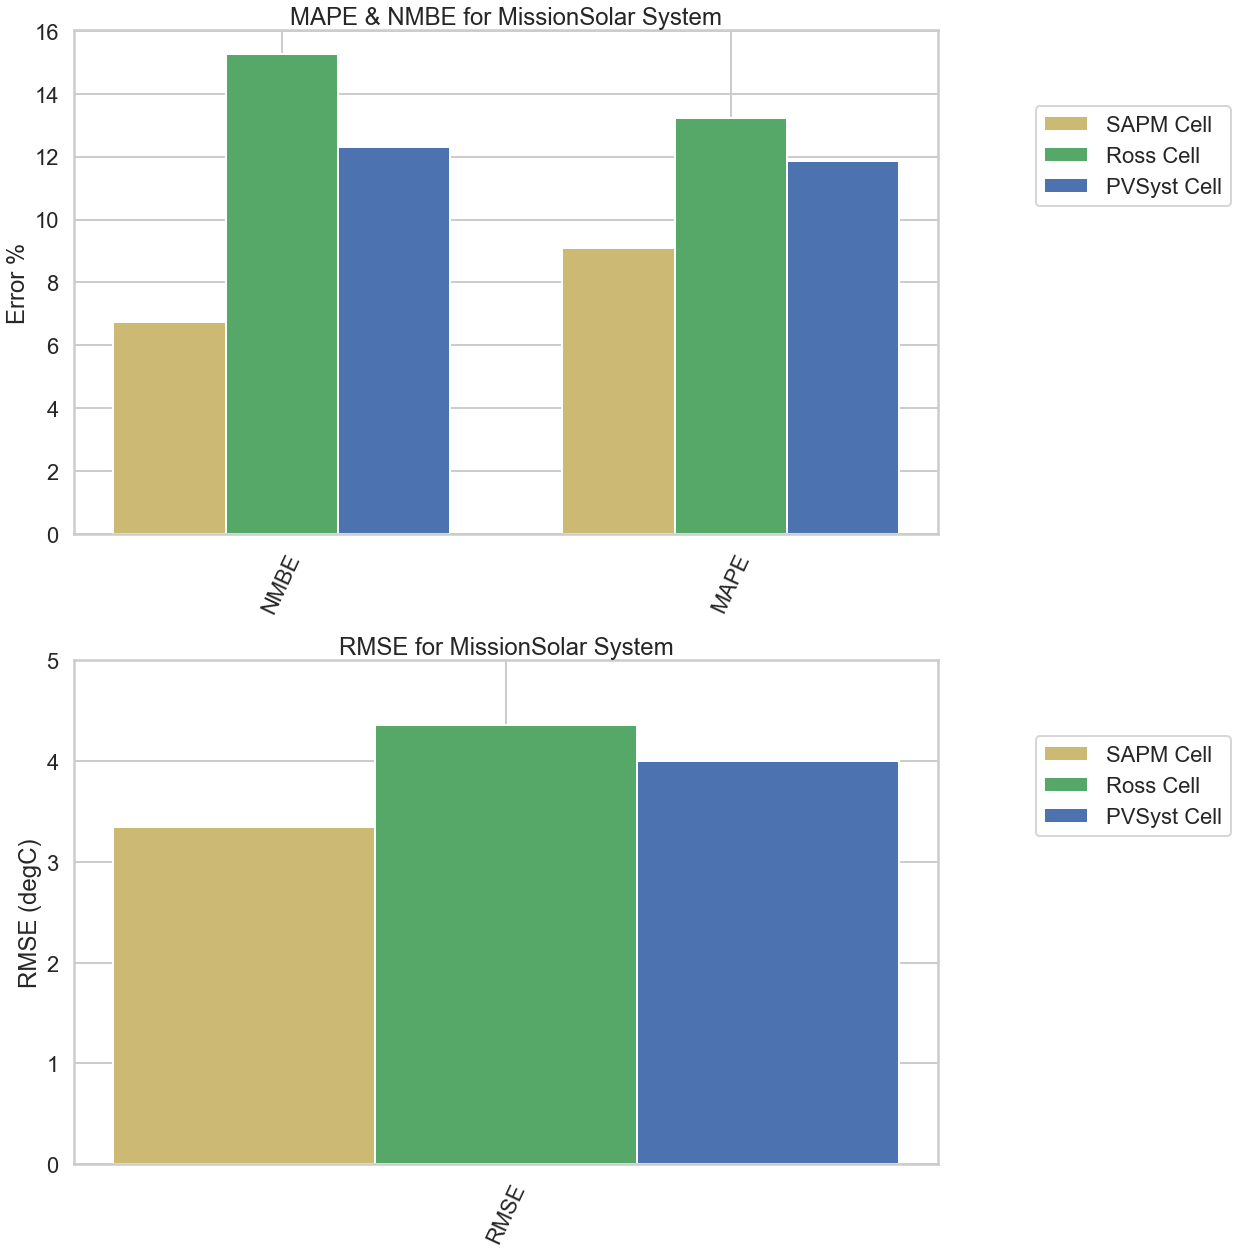

In [194]:
#Calculating RMSE/MAPE/
#need a df with no NaNs first
models = [model1,model2,model3]

X = np.arange(2)
fig, axis =plt.subplots(2, 1)
plt.title('MAPE, NMBE, & RMSE for '+system+' System')
axis[0] = fig.add_axes([0,1.25,1,1])
axis[0].bar(X + 0.00, sysresults.loc[sysresults['Model']==model1].iloc[:,[-3,-1]].mean(), color = 'y', width = 0.25)
axis[0].bar(X + 0.25, sysresults.loc[sysresults['Model']==model2].iloc[:,[-3,-1]].mean(), color = 'g', width = 0.25)
axis[0].bar(X + 0.50, sysresults.loc[sysresults['Model']==model3].iloc[:,[-3,-1]].mean(), color = 'b', width = 0.25)
axis[0].legend([model1,model2,model3] ,loc='center left', bbox_to_anchor=(1.1, 0.75))
axis[0].set_xticks([0.25, 1.25])
axis[0].set_xticklabels(['NMBE', 'MAPE'], rotation=65)
axis[0].set_ylabel('Error %')
axis[0].set_title('MAPE & NMBE for '+system+' System')

X = np.arange(1)
axis[1] = fig.add_axes([0,0,1,1])
axis[1].bar(X + 0.00, sysresults.loc[sysresults['Model']==model1].iloc[:,[-2]].mean(), color = 'y', width = 0.25)
axis[1].bar(X + 0.25, sysresults.loc[sysresults['Model']==model2].iloc[:,[-2]].mean(), color = 'g', width = 0.25)
axis[1].bar(X + 0.50, sysresults.loc[sysresults['Model']==model3].iloc[:,[-2]].mean(), color = 'b', width = 0.25)
axis[1].legend([model1,model2,model3] ,loc='center left', bbox_to_anchor=(1.1, 0.75))
axis[1].set_xticks([0.25])
axis[1].set_xticklabels(['RMSE'], rotation=65)
axis[1].set_ylabel('RMSE (degC)')
axis[1].set_title('RMSE for '+system+' System')
axis[1].set_ylim(0,5)


